## import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter,find_peaks
from tqdm import tqdm

import time
from collections import Counter
from pandas import Series

from impedance.visualization import plot_nyquist
from impedance import preprocessing

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel


In [2]:
import seaborn as sns

from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error


## import data

#### read Formation data

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
#load data from folder
df_form = read_mpr.mpr_pandas('raw_data/form')

In [5]:
read_mpr.searchmpr('raw_data/form')

['raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1t

In [6]:
df_form[3]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle,loop_Nr,cycle_Nr
0,23,0,1.411805e+05,-1.855859e-10,-1.855859e-10,0.00,2.097619,115,-1.855859e-10,0,0,1
1,23,0,1.411855e+05,0.000000e+00,-1.855859e-10,0.00,2.094193,115,-1.855859e-10,0,0,1
2,7,0,1.411906e+05,0.000000e+00,-1.855859e-10,-0.02,2.073522,117,-1.855859e-10,0,0,1
3,33,1,1.411906e+05,-1.112816e-08,-1.131375e-08,-0.02,2.073010,117,-1.131375e-08,0,0,1
4,1,1,1.411956e+05,-2.781651e-05,-2.782783e-05,-0.02,2.032771,117,-2.782783e-05,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
265690,7,1,2.311430e+06,0.000000e+00,-2.214351e-01,0.00,0.010400,115,-2.864958e+00,0,9,10
265691,7,1,2.311435e+06,0.000000e+00,-2.214351e-01,0.00,0.010361,115,-2.864958e+00,0,9,10
265692,7,1,2.311440e+06,0.000000e+00,-2.214351e-01,0.00,0.010322,115,-2.864958e+00,0,9,10
265693,7,1,2.311445e+06,0.000000e+00,-2.214351e-01,0.00,0.010440,115,-2.864958e+00,0,9,10


#### add serval columns

In [7]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/form/*.mpr')
datafilespath =  [os.path.basename(x) for x in datafilespath]

In [8]:
datafilespath

['Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA4.mpr',
 'Cell005_Form_100uA_25T_30RH_Cycle1to10_01_GEIS_CA5.mpr',
 'Cell005_For

#### half cycle and state of charge


In [9]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    df_form[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    df_form[index]['state of charge']=0
for index in cell_full_index:
    df_form[index]['state of charge']=1

In [10]:
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
discharge_index

array([ 3,  7, 11, 15, 19, 23, 27, 31])

#### read Cycling data

In [11]:
df_cycle = read_mpr.mpr_pandas('raw_data/cycle')

In [12]:
cyc_files = glob('raw_data/cycle/*.mpr')
for file in cyc_files:
    try:
        BioLogic.MPRfile(file)
    except:
        print('files: '+file+' is unreadable')

## Create EIS datasheets

In [14]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='Acakeren13!'
connection_name='SSB_Modelling'
db = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

EISdata = Series()

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)
    
    
    ##formation phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.form_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.form_geis WHERE `state of charge`=0'
    cellx_df_form = pd.read_sql(sql, Connection)
  
    
    for f in pd.unique(cellx_df_form['freq/Hz']):
        Z= cellx_df_form[cellx_df_form['freq/Hz']==f][['cycle_Nr','Re(Z)/Ohm','-Im(Z)/Ohm']]
        Z.columns = ['cycle_Nr','Re(Z)'+str(f),'-Im(Z)'+str(f)]
        if f==10001.0: 
            EISdata_form = Z
            Temp = EISdata_form
        else:
            EISdata_form = pd.merge(Z, Temp)
            Temp = EISdata_form
    EISdata_form.insert(EISdata_form.shape[1],'I(uA)',i)   
        
    
    ##cycling phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.cyc_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis' 
    cellx_df_cyc = pd.read_sql(sql, Connection)
    
    for f in pd.unique(cellx_df_cyc['freq/Hz']):
        Z_f = cellx_df_cyc[cellx_df_cyc['freq/Hz']==f]
        Z = Z_f[['cycle_Nr','Re(Z)/Ohm','-Im(Z)/Ohm']]
        Z.columns = ['cycle_Nr','Re(Z)'+str(f),'-Im(Z)'+str(f)]
        if f==10001.0: 
            EISdata_cyc = Z
            Temp = EISdata_cyc
        else:
            EISdata_cyc = pd.merge(Z, Temp)
            Temp = EISdata_cyc
    EISdata_cyc.insert(EISdata_cyc.shape[1],'I(uA)',i)
    
    
    ##combine two phases
    EISdata = pd.concat([EISdata, EISdata_form, EISdata_cyc])
   

<ipython-input-14-9e62368d61ab>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  EISdata = Series()


In [15]:
EISdata

,0,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,...,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063,cycle_Nr
0,NaN,46573.100,41140.600,38890.600,33659.900,28336.300,24173.400,20196.100,16555.000,13207.800,...,4069.380,780.681,19795.400,11042.900,3192.450,576.129,18729.900,9338.710,2468.640,1.0
1,NaN,744.727,680.813,646.593,610.109,590.529,556.290,536.941,519.400,501.626,...,1094.290,440.624,2186.520,1607.920,984.566,352.459,2090.170,1508.630,871.517,2.0
2,NaN,466.609,418.363,371.091,330.920,302.348,281.000,260.804,243.710,227.845,...,280.388,178.468,510.757,363.399,265.193,157.575,480.894,344.816,249.524,3.0
3,NaN,321.803,268.775,249.611,213.158,191.325,173.753,158.885,147.645,137.494,...,194.233,120.451,329.958,247.109,183.140,107.645,313.046,235.716,171.382,4.0
4,NaN,306.783,257.149,232.201,198.357,176.400,162.611,148.172,137.131,126.416,...,200.602,120.529,326.963,253.938,188.869,107.826,312.557,243.248,175.909,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NaN,928.158,787.140,746.442,658.180,608.807,571.038,539.620,511.625,481.045,...,610.890,297.738,1339.490,947.509,551.273,255.368,1273.070,877.947,494.135,51.0
5,NaN,950.003,851.159,748.695,695.747,650.527,607.119,567.820,532.886,503.491,...,654.759,311.267,1443.940,1021.890,589.334,265.472,1372.430,947.176,526.326,61.0
6,NaN,981.726,844.923,815.402,721.606,668.781,628.138,591.708,561.631,529.389,...,676.418,317.095,1513.180,1067.040,606.722,270.461,1438.550,987.266,540.827,71.0
7,NaN,1008.600,938.403,824.233,772.940,716.481,675.717,633.844,593.506,557.258,...,717.194,328.901,1621.590,1141.040,641.104,279.113,1541.250,1054.600,569.741,81.0


In [16]:
### du brauchst wahrscheinlich nur die Re und Im data davon, kein cycle und I(uA) columns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

In [17]:
# remove unnecessary columns

EISdata_defaultIndex = EISdata.reset_index()
EISdata_defaultIndex = EISdata_defaultIndex.rename({'index': 'loop_nr'}, axis=1).drop(columns=0, axis=1)
df = EISdata_defaultIndex.drop(['loop_nr', 'I(uA)'], axis=1)

In [18]:
# abnormal cycle from cycle 1 to specified n
abnormal_cycle = 3

df_unfilter = df.drop('cycle_Nr', axis=1)
df_abnormal = df.loc[df['cycle_Nr'] < abnormal_cycle].drop('cycle_Nr', axis=1)
df_normal = df.loc[df['cycle_Nr'] > abnormal_cycle].drop('cycle_Nr', axis=1)

# transform data
df_unfilter_trans = np.log2(df_unfilter) # try with log10 or log 2
df_normal_trans = np.log2(df_normal)
df_abnormal_trans = np.log2(df_abnormal)

In [19]:
# dividing dfs

df_im_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Re')))]
df_im_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Re')))]
df_re_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Im')))]
df_re_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Im')))]
df_im_unfilter = df_unfilter[df_unfilter.columns.drop(list(df_unfilter.filter(regex='Re')))]
df_re_unfilter = df_unfilter[df_unfilter.columns.drop(list(df_unfilter.filter(regex='Im')))]


## plot

<IPython.core.display.Javascript object>


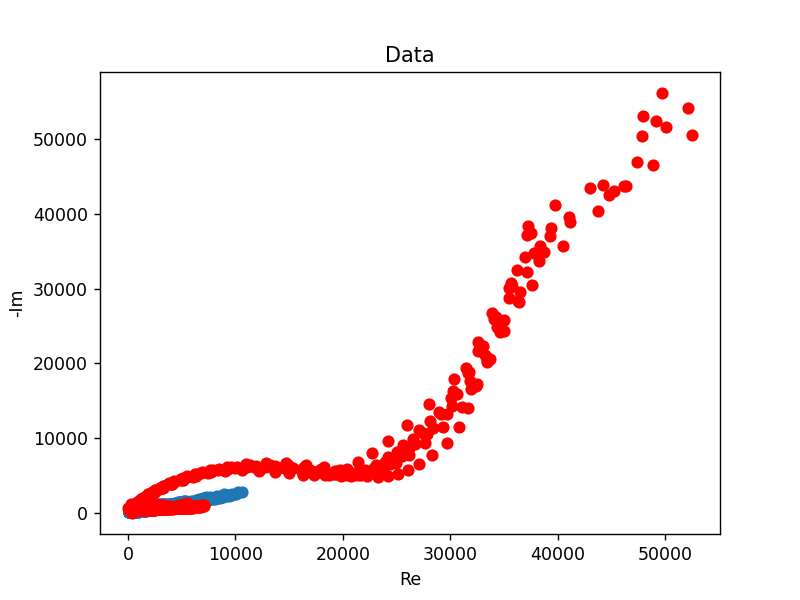

In [20]:
# normal and abnormal df comparison

plt.scatter(df_re_normal, df_im_normal)
plt.scatter(df_re_abnormal, df_im_abnormal, color='r')
plt.title('Data')
plt.ylabel('-Im')
plt.xlabel('Re')
plt.show()

In [21]:
df_im_unfilter_t = df_unfilter_trans[df_unfilter_trans.columns.drop(list(df_unfilter_trans.filter(regex='Re')))]
df_re_unfilter_t = df_unfilter_trans[df_unfilter_trans.columns.drop(list(df_unfilter_trans.filter(regex='Im')))]

<IPython.core.display.Javascript object>


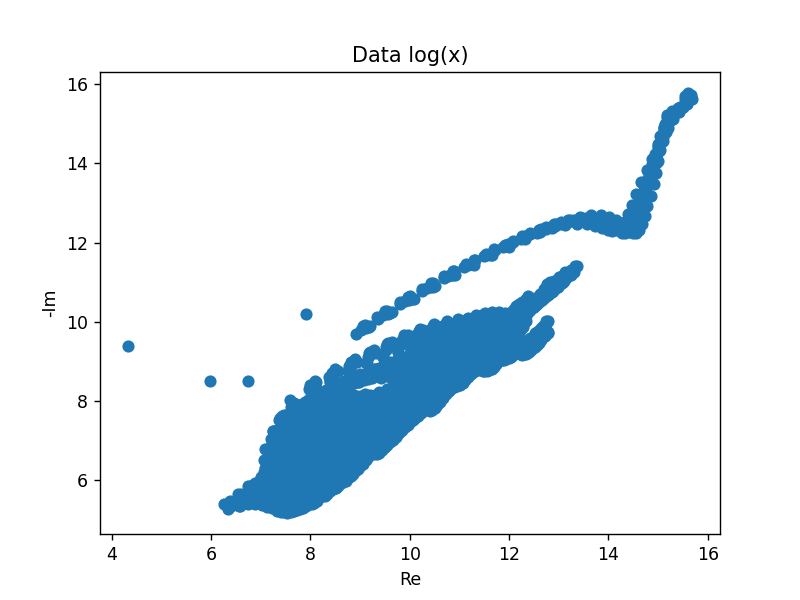

In [22]:
plt.scatter(df_re_unfilter_t, df_im_unfilter_t)
plt.title('Data log(x)')
plt.ylabel('-Im')
plt.xlabel('Re')
plt.show()

## training

probability distribution function

In [23]:
df_unfilter.describe()

,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,-Im(Z)0.349246,-Im(Z)0.516884,-Im(Z)0.768341,-Im(Z)1.14087,-Im(Z)1.69268,-Im(Z)10001.0,-Im(Z)12.184,-Im(Z)130.089,-Im(Z)1390.0,-Im(Z)18.077,-Im(Z)193.035,-Im(Z)2.51224,-Im(Z)2063.0,-Im(Z)26.8198,-Im(Z)286.568,-Im(Z)3.72762,-Im(Z)3061.0,-Im(Z)39.8047,-Im(Z)425.149,-Im(Z)4542.0,-Im(Z)5.53438,-Im(Z)59.0552,-Im(Z)630.738,-Im(Z)6740.0,-Im(Z)8.21194,-Im(Z)87.684,-Im(Z)936.063,Re(Z)0.00931323,Re(Z)0.0139698,Re(Z)0.0209548,Re(Z)0.0325963,Re(Z)0.0488944,Re(Z)0.0721775,Re(Z)0.107102,Re(Z)0.158325,Re(Z)0.235159,Re(Z)0.349246,Re(Z)0.516884,Re(Z)0.768341,Re(Z)1.14087,Re(Z)1.69268,Re(Z)10001.0,Re(Z)12.184,Re(Z)130.089,Re(Z)1390.0,Re(Z)18.077,Re(Z)193.035,Re(Z)2.51224,Re(Z)2063.0,Re(Z)26.8198,Re(Z)286.568,Re(Z)3.72762,Re(Z)3061.0,Re(Z)39.8047,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,3573.912151,3082.575952,2771.331000,2456.768767,2163.952582,1899.520692,1653.392897,1430.396630,1227.010473,1048.986514,900.806358,783.644449,694.152318,627.645221,150.335168,551.296556,555.782568,343.161134,566.324385,528.306586,581.123812,303.929268,580.096479,495.583560,552.509549,265.461913,588.012604,459.567592,228.623945,539.832234,586.899738,421.588964,194.146548,540.735892,575.950512,382.597056,5661.223781,5195.321473,4837.376021,4566.414384,4326.630740,4113.027479,3919.999753,3732.884986,3541.154877,3347.601425,3162.187404,2996.647507,2848.573521,2714.006534,185.424149,2104.485137,1196.166486,486.522199,1967.014486,1051.859774,2589.278774,405.779733,1819.540342,917.284822,2470.291014,335.814295,1664.582555,793.499445,276.173582,2352.793829,1506.234466,680.474226,226.336586,2232.303116,1348.512911,578.239062
std,11478.430470,9777.414072,8770.391484,7691.435647,6664.963137,5720.202461,4838.350252,4041.059704,3317.246615,2689.416167,2175.501950,1787.282574,1504.486118,1309.545271,134.929419,1220.242452,1253.980965,527.482544,1292.465313,1146.064616,1187.203557,427.016863,1353.234794,1021.846354,1127.268971,339.420098,1386.074476,891.605447,265.186997,1120.654850,1380.831457,762.376447,204.055501,1156.673632,1335.223489,640.018152,10745.910920,9574.841303,8761.425364,8306.645594,7897.800088,7543.854122,7252.639856,6959.425579,6626.275965,6257.463823,5889.079771,5577.838411,5313.814383,5079.524370,111.853002,3923.828680,1744.651856,390.699784,3610.599186,1418.663788,4864.238931,287.081588,3258.920131,1133.327681,4653.891807,207.884239,2879.594018,890.693209,148.977766,4436.345741,2489.307180,688.465895,106.263824,4197.091220,2105.178532,523.182251
min,274.759000,240.704000,206.137000,188.537000,169.667000,153.177000,139.889000,127.088000,117.100000,108.332000,99.805200,91.991800,84.467300,77.610100,-41.073900,49.950300,36.963400,40.314200,45.433000,36.180300,71.266300,41.664700,43.266600,36.858100,64.688100,42.351900,41.178300,36.992600,42.409100,58.883600,39.482800,37.662900,41.141100,54.052900,37.783600,39.337200,774.809000,735.390000,681.844000,633.487000,589.479000,553.394000,516.101000,484.450000,454.161000,425.793000,400.933000,375.593000,353.442000,332.

In [24]:
df_normal.describe()

,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,-Im(Z)0.349246,-Im(Z)0.516884,-Im(Z)0.768341,-Im(Z)1.14087,-Im(Z)1.69268,-Im(Z)10001.0,-Im(Z)12.184,-Im(Z)130.089,-Im(Z)1390.0,-Im(Z)18.077,-Im(Z)193.035,-Im(Z)2.51224,-Im(Z)2063.0,-Im(Z)26.8198,-Im(Z)286.568,-Im(Z)3.72762,-Im(Z)3061.0,-Im(Z)39.8047,-Im(Z)425.149,-Im(Z)4542.0,-Im(Z)5.53438,-Im(Z)59.0552,-Im(Z)630.738,-Im(Z)6740.0,-Im(Z)8.21194,-Im(Z)87.684,-Im(Z)936.063,Re(Z)0.00931323,Re(Z)0.0139698,Re(Z)0.0209548,Re(Z)0.0325963,Re(Z)0.0488944,Re(Z)0.0721775,Re(Z)0.107102,Re(Z)0.158325,Re(Z)0.235159,Re(Z)0.349246,Re(Z)0.516884,Re(Z)0.768341,Re(Z)1.14087,Re(Z)1.69268,Re(Z)10001.0,Re(Z)12.184,Re(Z)130.089,Re(Z)1390.0,Re(Z)18.077,Re(Z)193.035,Re(Z)2.51224,Re(Z)2063.0,Re(Z)26.8198,Re(Z)286.568,Re(Z)3.72762,Re(Z)3061.0,Re(Z)39.8047,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.00000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.00000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,828.387672,742.132492,671.103861,613.251975,567.739574,529.166852,494.324836,462.007025,431.520910,402.957131,376.201379,349.86153,326.420635,304.872059,115.351361,241.246402,223.327348,190.291348,236.615618,220.665347,286.031816,178.432731,233.240636,217.431836,270.179305,164.492409,230.537669,213.134370,148.942646,257.449845,228.046971,207.477725,132.434707,247.956278,225.752608,199.931225,2933.382311,2757.169385,2594.687451,2429.608934,2286.15791,2156.479639,2032.389418,1915.312590,1804.269115,1700.666385,1605.381787,1516.473213,1433.867115,1357.827852,164.863226,1041.043475,697.241762,368.084582,983.319377,640.834607,1287.219631,319.009918,925.706680,584.634230,1221.403246,273.639098,868.236787,528.887779,232.553631,1159.087975,811.038254,473.856213,196.309119,1099.384992,753.927885,420.090172
std,528.962136,480.231655,440.029574,407.909095,380.359079,354.967215,331.465365,309.254428,288.912325,270.773820,253.877590,240.04102,228.634114,220.677920,58.184651,228.301421,183.913534,122.580088,231.071235,171.565628,216.322022,110.932024,229.235556,160.662614,215.644813,98.174919,222.168572,151.163643,84.559528,218.272799,210.903742,142.129887,71.138989,223.170131,197.428352,132.845658,2014.332146,1901.799868,1789.010601,1677.713886,1578.70976,1490.783587,1407.064053,1327.750509,1254.624730,1187.725443,1126.595092,1069.644462,1015.627453,964.678799,48.370067,709.989734,384.751932,156.538932,652.334848,341.557758,915.500724,126.948114,593.569262,300.693904,866.725914,101.203268,536.083731,261.748909,79.535657,816.924531,481.664871,224.661662,62.070464,764.916995,431.240168,189.366465
min,274.759000,240.704000,206.137000,188.537000,169.667000,153.177000,139.889000,127.088000,117.100000,108.332000,99.805200,91.99180,84.467300,77.610100,38.693800,49.950300,36.963400,40.314200,45.433000,36.180300,71.266300,41.664700,43.266600,36.858100,64.688100,42.351900,41.178300,36.992600,42.409100,58.883600,39.482800,37.662900,41.141100,54.052900,37.783600,39.337200,774.809000,735.390000,681.844000,633.487000,589.47900,553.394000,516.101000,484.450000,454.161000,425.793000,400.933000,375.593000,353.442000,332.643000,76.578700,253.335000,194.204000,140.466000,241.530000,185.831000,313.

<IPython.core.display.Javascript object>


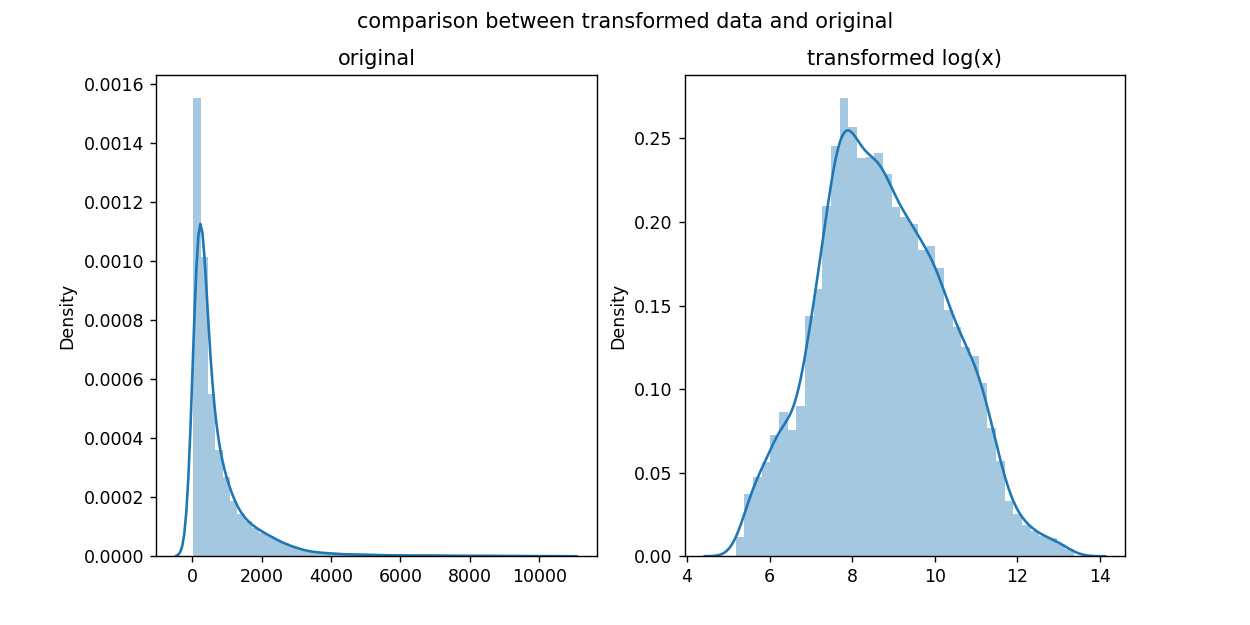

G:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'transformed log(x)'}, ylabel='Density'>

In [46]:
# more gaussian

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('comparison between transformed data and original')

axes[0].set_title('original')
sns.distplot(df_normal, ax=axes[0])

axes[1].set_title('transformed log(x)')
sns.distplot(df_normal_trans, ax=axes[1])


In [47]:
good_samples_train, good_samples_crv, good_samples_test = np.split(df_normal_trans.sample(frac=1, random_state=42), 
                                                            [int(.6*len(df_normal_trans)), int(.8*len(df_normal_trans))])

abnormal_samples_crv, abnormal_samples_test = train_test_split(df_abnormal_trans, test_size=0.5)

print('good samples: \n  train: {}\n  crv:    {}\n  test:  {}'.format(good_samples_train.shape, 
                                                                     good_samples_crv.shape, 
                                                                     good_samples_test.shape))

good samples: 
  train: (73, 72)
  crv:    (24, 72)
  test:  (25, 72)


In [48]:
good_samples_train.describe()

,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,-Im(Z)0.349246,-Im(Z)0.516884,-Im(Z)0.768341,-Im(Z)1.14087,-Im(Z)1.69268,-Im(Z)10001.0,-Im(Z)12.184,-Im(Z)130.089,-Im(Z)1390.0,-Im(Z)18.077,-Im(Z)193.035,-Im(Z)2.51224,-Im(Z)2063.0,-Im(Z)26.8198,-Im(Z)286.568,-Im(Z)3.72762,-Im(Z)3061.0,-Im(Z)39.8047,-Im(Z)425.149,-Im(Z)4542.0,-Im(Z)5.53438,-Im(Z)59.0552,-Im(Z)630.738,-Im(Z)6740.0,-Im(Z)8.21194,-Im(Z)87.684,-Im(Z)936.063,Re(Z)0.00931323,Re(Z)0.0139698,Re(Z)0.0209548,Re(Z)0.0325963,Re(Z)0.0488944,Re(Z)0.0721775,Re(Z)0.107102,Re(Z)0.158325,Re(Z)0.235159,Re(Z)0.349246,Re(Z)0.516884,Re(Z)0.768341,Re(Z)1.14087,Re(Z)1.69268,Re(Z)10001.0,Re(Z)12.184,Re(Z)130.089,Re(Z)1390.0,Re(Z)18.077,Re(Z)193.035,Re(Z)2.51224,Re(Z)2063.0,Re(Z)26.8198,Re(Z)286.568,Re(Z)3.72762,Re(Z)3061.0,Re(Z)39.8047,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,9.461429,9.301865,9.146562,9.011329,8.893069,8.786911,8.684049,8.582296,8.480288,8.378396,8.276037,8.165420,8.058480,7.950227,6.641858,7.516481,7.417729,7.274704,7.470313,7.417434,7.845160,7.195080,7.440334,7.413453,7.745392,7.092545,7.423117,7.399010,6.967677,7.655692,7.415476,7.374873,6.818748,7.578524,7.415521,7.333970,11.245925,11.155456,11.067063,10.970384,10.881532,10.797094,10.710688,10.624446,10.537409,10.450963,10.366895,10.283386,10.201738,10.122536,7.303785,9.751498,9.230649,8.377820,9.676809,9.118374,10.045516,8.187996,9.598871,8.995940,9.970621,7.984640,9.516483,8.861659,7.767965,9.897191,9.428652,8.714445,7.540967,9.824659,9.333517,8.553766
std,0.855985,0.870537,0.882286,0.899423,0.912588,0.920614,0.926521,0.930231,0.933109,0.936590,0.939909,0.945897,0.955995,0.970917,0.765278,1.126322,1.178059,0.964958,1.160244,1.153819,0.991331,0.925035,1.184980,1.120788,1.019687,0.886212,1.199881,1.085087,0.845129,1.052497,1.203968,1.044368,0.804061,1.089165,1.196223,1.003805,0.942466,0.947398,0.948862,0.951438,0.952910,0.954148,0.955645,0.956645,0.958418,0.960795,0.963918,0.967616,0.970933,0.974103,0.459585,0.963435,0.837757,0.651019,0.950771,0.810615,0.976388,0.612437,0.933888,0.782015,0.977199,0.571849,0.913372,0.752041,0.531123,0.975868,0.889870,0.720866,0.493046,0.971404,0.864547,0.687133
min,8.102023,7.911116,7.687460,7.558704,7.406562,7.259056,7.128139,6.989684,6.871597,6.759316,6.641043,6.523433,6.400321,6.278173,5.345811,5.642421,5.265126,5.464093,5.505669,5.290465,6.155148,5.503371,5.435182,5.333731,6.015428,5.512002,5.363812,5.392723,5.510674,5.879794,5.303152,5.462651,5.468486,5.756300,5.283770,5.474196,9.597697,9.522366,9.415528,9.311235,9.208912,9.122274,9.034914,8.937312,8.840866,8.749826,8.665425,8.577720,8.496083,8.417186,6.258871,8.074200,7.690180,7.138855,8.015911,7.609556,8.343079,7.007364,7.961594,7.522079,8.269636,6.864719,7.905700,7.442728,6.699441,8.200217,7.845089,7.348312,6.502830,8.136320,7.767794,7.243498
25%,8.817323,8.667261,8.477746,8.307187,8.176996,8.035398,7.914313,7.835716,7.757943,7.672263,7.559201,7.455130,7.329626,7.201575,6.091662,6.693138,6.372000,6.479038,6.590274,6.379169,7.063783,6.424679,6.492940,6.394483,6.921163,6.335774,6.422749,6.449414,6.237631,6.834168,6.406732,6.483937,6.148218,6.7885

In [49]:
# variant 1 of probability using multivariate normal probability distribution function
# this is preferred

def probability(df):
    # mean, covariance matrix
    mean = df.mean()
    cov_matrix = np.diag(np.std(df))
    
    from scipy.stats import multivariate_normal
    var = multivariate_normal.pdf(np.array(df), mean=mean, cov=cov_matrix)
    
    # return probability
    return pd.DataFrame(var, columns=['P(X)'])

In [50]:
# variant 2 of probability
# one to one
from scipy.stats import norm

def probability2(df):
    prob = pd.DataFrame(columns=df.columns)
    for count, col in enumerate(df):
        x = df[col]
        mean = df.mean()
        var = np.std(df)
        prob[col] = norm.pdf(df[col], loc=mean[count], scale=var[count])

        return prob

In [51]:
good_p = probability(good_samples_train)

In [52]:
good_p

,P(X)
0,1.142774e-50
1,1.140651e-54
2,5.975845e-42
3,6.203155e-32
4,1.719986e-47
5,1.624391e-28
6,7.777562e-46
7,1.920434e-28
8,5.405837e-44
9,4.671248e-28


## cross validation

In [53]:
# label of normal/abnormal, normal = 0, abnormal = 1 based on abnormal cycle number above
label_good = pd.DataFrame(0, index=good_samples_crv.index, columns=['normal/abnormal'])
label_abnormal = pd.DataFrame(1, index=abnormal_samples_crv.index, columns=['normal/abnormal'])


print('abnormal samples shape: {}\nnormal samples shape: {}'.format(abnormal_samples_crv.shape, good_samples_crv.shape))

# combine the two
dfs = [abnormal_samples_crv, good_samples_crv]
labels = [label_abnormal, label_good]
crv = pd.concat(dfs)
crv_label = pd.concat(labels)

#random num to randomize the index (applies to both label and samples)
idx = np.random.permutation(crv.index)
crv = crv.loc[idx]
crv_label = crv_label.loc[idx]

# cross validation probability
crv_p = probability(crv)
crv_label = np.array(crv_label)
crv['normal/abnormal'] = crv_label
crv = crv[['normal/abnormal']+list(crv.columns)]


print('cross validation shape: {}'.format(crv_p.shape))

abnormal samples shape: (8, 72)
normal samples shape: (24, 72)
cross validation shape: (32, 1)


In [54]:
crv

,normal/abnormal,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,-Im(Z)0.349246,-Im(Z)0.516884,-Im(Z)0.768341,-Im(Z)1.14087,-Im(Z)1.69268,-Im(Z)10001.0,-Im(Z)12.184,-Im(Z)130.089,-Im(Z)1390.0,-Im(Z)18.077,-Im(Z)193.035,-Im(Z)2.51224,-Im(Z)2063.0,-Im(Z)26.8198,-Im(Z)286.568,-Im(Z)3.72762,-Im(Z)3061.0,-Im(Z)39.8047,-Im(Z)425.149,-Im(Z)4542.0,-Im(Z)5.53438,-Im(Z)59.0552,-Im(Z)630.738,-Im(Z)6740.0,-Im(Z)8.21194,-Im(Z)87.684,-Im(Z)936.063,Re(Z)0.00931323,Re(Z)0.0139698,Re(Z)0.0209548,Re(Z)0.0325963,Re(Z)0.0488944,Re(Z)0.0721775,Re(Z)0.107102,Re(Z)0.158325,Re(Z)0.235159,Re(Z)0.349246,Re(Z)0.516884,Re(Z)0.768341,Re(Z)1.14087,Re(Z)1.69268,Re(Z)10001.0,Re(Z)12.184,Re(Z)130.089,Re(Z)1390.0,Re(Z)18.077,Re(Z)193.035,Re(Z)2.51224,Re(Z)2063.0,Re(Z)26.8198,Re(Z)286.568,Re(Z)3.72762,Re(Z)3061.0,Re(Z)39.8047,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063,normal/abnormal
116,0,9.871647,9.752827,9.499401,9.390085,9.270821,9.160754,9.058779,8.950285,8.855202,8.772024,8.675886,8.588355,8.492883,8.396733,7.196351,7.955359,7.861713,7.972589,7.895915,7.897053,8.299190,7.910241,7.853759,7.929022,8.205329,7.811677,7.830864,7.964618,7.664817,8.111308,7.827584,7.988901,7.475466,8.028873,7.836113,7.995077,11.648519,11.565878,11.475896,11.382586,11.295717,11.217661,11.140012,11.055160,10.969099,10.884720,10.805800,10.722714,10.644361,10.565940,7.382218,10.197634,9.723866,8.831510,10.127066,9.621098,10.490540,8.591178,10.054211,9.502834,10.416016,8.321644,9.980354,9.371250,8.032487,10.342275,9.901660,9.218282,7.725332,10.269594,9.816939,9.038897,0
99,0,10.595808,10.422801,10.391942,10.240994,10.145792,10.061709,9.978081,9.906162,9.820010,9.716979,9.609899,9.510038,9.394143,9.272849,7.267779,8.655159,8.146299,7.981836,8.539671,8.114034,9.152244,7.910403,8.434032,8.091790,9.025818,7.803518,8.340077,8.073772,7.652859,8.900665,8.261451,8.055993,7.464391,8.775258,8.193658,8.029066,12.351958,12.239897,12.138832,12.029501,11.925503,11.817092,11.707118,11.602184,11.494951,11.386116,11.268320,11.156627,11.039954,10.924048,7.547288,10.378620,9.758393,8.842457,10.275321,9.643694,10.810789,8.616038,10.173977,9.517215,10.700223,8.359082,10.073619,9.377187,8.076768,10.590063,9.971845,9.219940,7.775064,10.483483,9.867033,9.043391,0
128,1,9.958360,9.817796,9.773492,9.682601,9.617824,9.534192,9.465756,9.400768,9.345882,9.301270,9.249535,9.233215,9.219461,9.223941,8.271925,9.564066,9.963218,9.547966,9.662766,9.962923,9.257204,9.365684,9.754647,9.939616,9.307315,9.146487,9.834763,9.888516,8.895000,9.380327,9.896985,9.809054,8.613053,9.467477,9.940877,9.695127,12.751665,12.709752,12.649503,12.605477,12.561450,12.513811,12.473292,12.424749,12.377642,12.335362,12.294319,12.252908,12.211475,12.169784,8.125785,11.910350,11.249137,9.846735,11.835565,11.077717,12.127072,9.523760,11.748809,10.883735,12.081141,9.180665,11.648492,10.664590,8.825515,12.031529,11.532853,10.419455,8.463324,11.975042,11.400063,10.146276,1
127,1,15.696579,15.377621,15.182049,14.985566,14.808079,14.601452,14.365516,14.105393,13.798674,13.469044,13.168589,12.895878,12.659033,12.478388,8.966433,12.440303,12.478699,11.190695,12.528513,12.340768,12.351751,10.888218,12.597641,12.165331,12.293262,10.562166,12.633504,11.959542,10.211827,12.299723,12.627247,11.726137,9.845233,12.355464,12.575066,11.470227,15.548286,15.450506,15.182228,15.144686,15.114218,15.066964,15.020103,14.959961,14.880421,14.793243,14.707262,14.640307,14.572505,14.509688,9.713880,14.138888,12.950738,10.834795,14.017809,12.648292,14.448807,10.417620,13.867935,12.323120,14.385579,9.986638,13.686894,11.978535,9.552004,14.316720,13.473186,11.615676,9.122722,14.236455,13.226546,11.234536,1
66,0,9.332558,9.257484,9.095007,9.052285,8.980137,8.898190,8.817812,8.723108,8.626647,8.532636,8.403067,8.282704,8.139434,8.002978,6.491454,7.438276,7.423713,7.192155,7.383151,7.449140,7.866265,7.066972,7.

In [55]:
crv_label

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=int64)

In [56]:
# 0 normal, 1 abnormal

crv

,normal/abnormal,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,-Im(Z)0.349246,-Im(Z)0.516884,-Im(Z)0.768341,-Im(Z)1.14087,-Im(Z)1.69268,-Im(Z)10001.0,-Im(Z)12.184,-Im(Z)130.089,-Im(Z)1390.0,-Im(Z)18.077,-Im(Z)193.035,-Im(Z)2.51224,-Im(Z)2063.0,-Im(Z)26.8198,-Im(Z)286.568,-Im(Z)3.72762,-Im(Z)3061.0,-Im(Z)39.8047,-Im(Z)425.149,-Im(Z)4542.0,-Im(Z)5.53438,-Im(Z)59.0552,-Im(Z)630.738,-Im(Z)6740.0,-Im(Z)8.21194,-Im(Z)87.684,-Im(Z)936.063,Re(Z)0.00931323,Re(Z)0.0139698,Re(Z)0.0209548,Re(Z)0.0325963,Re(Z)0.0488944,Re(Z)0.0721775,Re(Z)0.107102,Re(Z)0.158325,Re(Z)0.235159,Re(Z)0.349246,Re(Z)0.516884,Re(Z)0.768341,Re(Z)1.14087,Re(Z)1.69268,Re(Z)10001.0,Re(Z)12.184,Re(Z)130.089,Re(Z)1390.0,Re(Z)18.077,Re(Z)193.035,Re(Z)2.51224,Re(Z)2063.0,Re(Z)26.8198,Re(Z)286.568,Re(Z)3.72762,Re(Z)3061.0,Re(Z)39.8047,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063,normal/abnormal
116,0,9.871647,9.752827,9.499401,9.390085,9.270821,9.160754,9.058779,8.950285,8.855202,8.772024,8.675886,8.588355,8.492883,8.396733,7.196351,7.955359,7.861713,7.972589,7.895915,7.897053,8.299190,7.910241,7.853759,7.929022,8.205329,7.811677,7.830864,7.964618,7.664817,8.111308,7.827584,7.988901,7.475466,8.028873,7.836113,7.995077,11.648519,11.565878,11.475896,11.382586,11.295717,11.217661,11.140012,11.055160,10.969099,10.884720,10.805800,10.722714,10.644361,10.565940,7.382218,10.197634,9.723866,8.831510,10.127066,9.621098,10.490540,8.591178,10.054211,9.502834,10.416016,8.321644,9.980354,9.371250,8.032487,10.342275,9.901660,9.218282,7.725332,10.269594,9.816939,9.038897,0
99,0,10.595808,10.422801,10.391942,10.240994,10.145792,10.061709,9.978081,9.906162,9.820010,9.716979,9.609899,9.510038,9.394143,9.272849,7.267779,8.655159,8.146299,7.981836,8.539671,8.114034,9.152244,7.910403,8.434032,8.091790,9.025818,7.803518,8.340077,8.073772,7.652859,8.900665,8.261451,8.055993,7.464391,8.775258,8.193658,8.029066,12.351958,12.239897,12.138832,12.029501,11.925503,11.817092,11.707118,11.602184,11.494951,11.386116,11.268320,11.156627,11.039954,10.924048,7.547288,10.378620,9.758393,8.842457,10.275321,9.643694,10.810789,8.616038,10.173977,9.517215,10.700223,8.359082,10.073619,9.377187,8.076768,10.590063,9.971845,9.219940,7.775064,10.483483,9.867033,9.043391,0
128,1,9.958360,9.817796,9.773492,9.682601,9.617824,9.534192,9.465756,9.400768,9.345882,9.301270,9.249535,9.233215,9.219461,9.223941,8.271925,9.564066,9.963218,9.547966,9.662766,9.962923,9.257204,9.365684,9.754647,9.939616,9.307315,9.146487,9.834763,9.888516,8.895000,9.380327,9.896985,9.809054,8.613053,9.467477,9.940877,9.695127,12.751665,12.709752,12.649503,12.605477,12.561450,12.513811,12.473292,12.424749,12.377642,12.335362,12.294319,12.252908,12.211475,12.169784,8.125785,11.910350,11.249137,9.846735,11.835565,11.077717,12.127072,9.523760,11.748809,10.883735,12.081141,9.180665,11.648492,10.664590,8.825515,12.031529,11.532853,10.419455,8.463324,11.975042,11.400063,10.146276,1
127,1,15.696579,15.377621,15.182049,14.985566,14.808079,14.601452,14.365516,14.105393,13.798674,13.469044,13.168589,12.895878,12.659033,12.478388,8.966433,12.440303,12.478699,11.190695,12.528513,12.340768,12.351751,10.888218,12.597641,12.165331,12.293262,10.562166,12.633504,11.959542,10.211827,12.299723,12.627247,11.726137,9.845233,12.355464,12.575066,11.470227,15.548286,15.450506,15.182228,15.144686,15.114218,15.066964,15.020103,14.959961,14.880421,14.793243,14.707262,14.640307,14.572505,14.509688,9.713880,14.138888,12.950738,10.834795,14.017809,12.648292,14.448807,10.417620,13.867935,12.323120,14.385579,9.986638,13.686894,11.978535,9.552004,14.316720,13.473186,11.615676,9.122722,14.236455,13.226546,11.234536,1
66,0,9.332558,9.257484,9.095007,9.052285,8.980137,8.898190,8.817812,8.723108,8.626647,8.532636,8.403067,8.282704,8.139434,8.002978,6.491454,7.438276,7.423713,7.192155,7.383151,7.449140,7.866265,7.066972,7.

In [57]:
crv_p

,P(X)
0,1.075820e-36
1,9.958407e-36
2,6.331767e-47
3,5.985287e-161
4,1.221456e-43
5,9.185824e-39
6,1.827051e-65
7,1.317877e-37
8,2.728206e-37
9,4.850072e-40


### select epsilon

In [58]:
# function to calculate true positives, false positives, and false negatives

def tpfpfn(ep, p):
    tp, fp, fn = 0, 0, 0
    for i in range(len(crv_label)):
        if p[i] <= ep and crv_label[i][0] == 1:
            tp += 1
        elif p[i] <= ep and crv_label[i][0] == 0:
            fp += 1
        elif p[i] > ep and crv_label[i][0] == 1:
            fn += 1
    return tp, fp, fn

# calculate f1 score

def f1(ep, p):
    try:
        tp, fp, fn = tpfpfn(ep, p)
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        f1 = 2*prec*rec/(prec + rec)
    except ZeroDivisionError:
        f1 = 0
    return f1

In [59]:
# epsilon

threshold = crv_p.mean()[0]

epsilon = []
for i in np.array(crv_p):
    ep = i[0]
    if ep <= threshold and ep != 0:
        epsilon.append(ep)

# find the f1 score for each epsilon and probability

f = []
for i in epsilon:
    f.append(f1(i, np.array(crv_p)))

In [60]:
# epsilon variable to use for all anomaly measurement
e = epsilon[np.array(f).argmax()]
e

1.0965269308617724e-44

## test

In [61]:
# returns a list of labels where anomaly = 1 and 0 otherwise
def detect_anomaly(df, ep):
    # test probability
    # label each with 1 if probability is smaller than epsilon
    df_t = df
    df_p = np.array(probability(df))
    label = []
    for i in range(len(df_t)):
        if np.array(df_p)[i] <= ep:
            label.append(1)
        else:
            label.append(0)
    return label

# plot
def graph_anom(df_anomaly):
    df_im_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 1]
    df_im_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 0]

    df_re_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 1]
    df_re_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 0]
    
    plt.title("Anomalies")
    
    plt.scatter(df_re_anomaly, df_im_anomaly, c='red', label='anomaly') # re and -im
    plt.scatter(df_re_good, df_im_good, label='good')
    plt.xlabel('Re')
    plt.ylabel('-Im')
    plt.legend()
    plt.show()

In [62]:
# test dataset

dfs = [abnormal_samples_test, good_samples_test]
df_test = pd.concat(dfs)


<IPython.core.display.Javascript object>


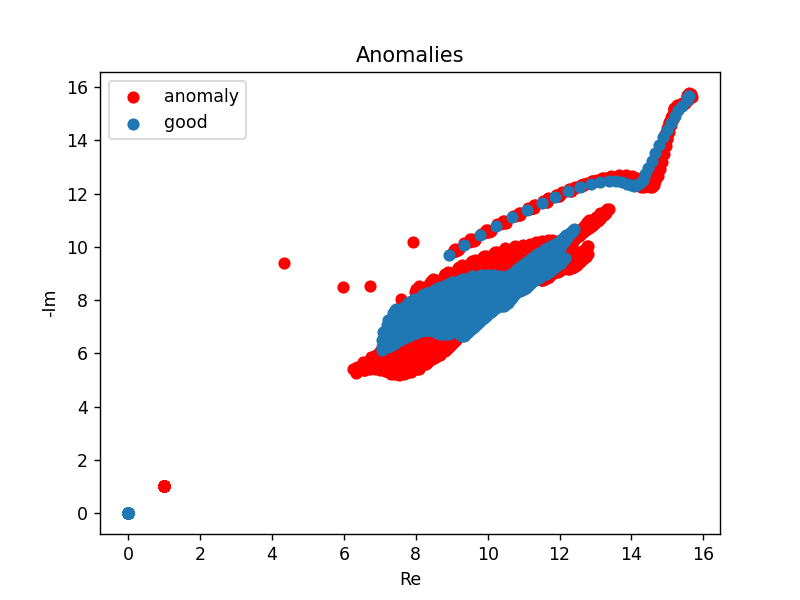

In [63]:
# anomaly detection with the whole dataset

df_unfilter_trans['label'] = detect_anomaly(df_unfilter_trans, e)
graph_anom(df_unfilter_trans)

<IPython.core.display.Javascript object>


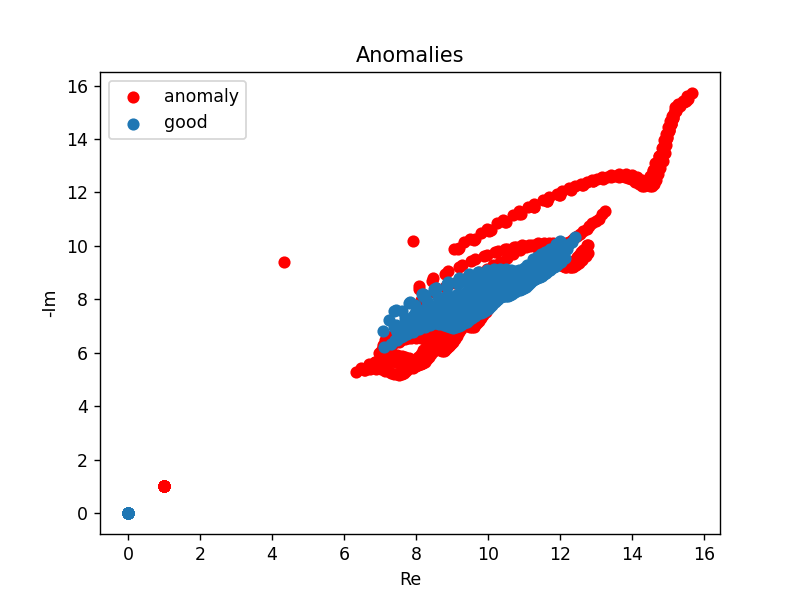

In [64]:
# plotting with test data get good result

df_test['label'] = detect_anomaly(df_test, e)
graph_anom(df_test)